In [1]:
import pandas as pd
import glob
import os 
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import glob
import random

from tqdm import tqdm

In [2]:
tr = pd.read_csv("../data/train.csv")
trl = pd.read_csv("../data/train_localizers.csv")


In [3]:
import multiprocessing
import os
import time

In [4]:
def getsz(uid):
    files = list(glob.glob(f"../data/series/{uid}/*.dcm"))
    img = pydicom.dcmread(files[0])
    if len(img.pixel_array.shape) == 3:
        return uid,img.pixel_array.shape[1],img.pixel_array.shape[2]
    
    return uid,img.pixel_array.shape[0],img.pixel_array.shape[1]

In [ ]:

uids = list(tr["SeriesInstanceUID"])

with multiprocessing.Pool(processes=16) as pool:

    data = pool.map(getsz, uids)


In [49]:
szdf = pd.DataFrame({ "SeriesInstanceUID": [s[0] for s in data]
                    , "height": [s[1] for s in data]
                    , "width": [s[2] for s in data]
                    }
                   )

In [50]:
szdf.iloc[:,1:].describe()

,height,width
count,4405.000000,4405.000000
mean,507.320091,494.674461
std,113.190796,113.196997
min,192.000000,176.000000
25%,512.000000,512.000000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,1024.000000,1024.000000


In [58]:
import numpy as np

In [65]:
def viewinstance(uid,level, around):
    files = list(glob.glob(f"../data/series/{uid}/*.dcm"))

    lvls = []
    for f in files:
        lvls.append((int(pydicom.dcmread(f).InstanceNumber),f))

    lvls = sorted(lvls)
    print(len(lvls))

    lvls = [*filter(lambda lvl:  abs(lvl[0] - level) <= around, lvls)]
    
    for lvl,f in lvls:
        img = pydicom.dcmread(f).pixel_array
        print(img.shape,np.min(img), np.max(img),img.dtype)
        fig, ax = plt.subplots()
        if len(img.shape) > 2:
            continue
        ax.imshow(img)
        # rect = patches.Rectangle((c["x"]-10, c["y"]-10), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        plt.show()
    
    

188
(512, 512) 0 362 int16


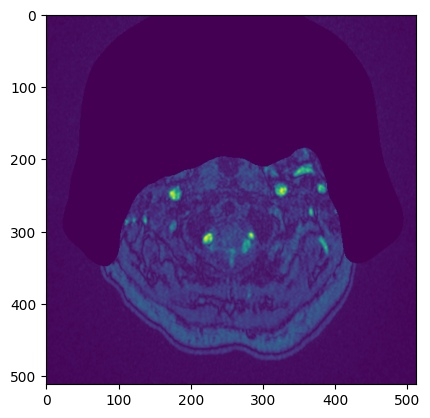

In [69]:
viewinstance(szdf.iloc[0,0], 0, 1)

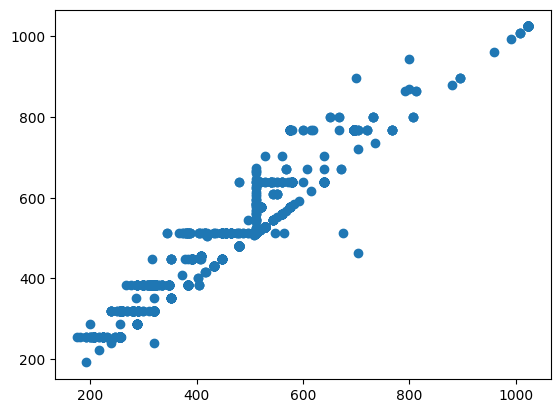

In [52]:
plt.scatter(x=szdf["width"],y=szdf["height"])
# plt.



1. Filter the uids that we don't wanna use
2. Create 5-Folds
3. create volumes

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import ast
import pydicom

import multiprocessing

from pathlib import Path
import os
import pydicom
import cv2

/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


In [2]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [3]:
ignore_uids = [
    "1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068",
    "1.2.826.0.1.3680043.8.498.35204126697881966597435252550544407444",
    "1.2.826.0.1.3680043.8.498.87480891990277582946346790136781912242"
] + list(mf_dicom_uids["SeriesInstanceUID"])
train_df = train_df[~train_df["SeriesInstanceUID"].isin(ignore_uids)].reset_index(drop=True)

In [4]:
train_df["fold_id"] = 0

In [5]:
sgkf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

for i, (train_index, test_index) in enumerate(sgkf.split(train_df["SeriesInstanceUID"], train_df["Aneurysm Present"])):
    train_df.loc[test_index, "fold_id"] =  i 

In [6]:
label_df["x"] = [s['x'] for s in list(label_df["coordinates"].map(ast.literal_eval)) ]
label_df["y"] = [s['y'] for s in list(label_df["coordinates"].map(ast.literal_eval)) ]
label_df["z"] = -1



In [7]:

# uid_t = "1.2.826.0.1.3680043.8.498.10134365079002163886508836892471866754"

In [8]:
def calculate_z_coord():
    for idx,rowdf in label_df.iterrows():
        uid,f = rowdf["SeriesInstanceUID"],rowdf["SOPInstanceUID"]

        label_df.loc[idx,'z'] = int(pydicom.dcmread(f"../data/series/{uid}/{f}.dcm").InstanceNumber) - 1
        
    

In [9]:
calculate_z_coord()

In [10]:
del label_df["coordinates"]

In [11]:
label_df.head()

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.359900,162
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,Right Middle Cerebral Artery,194.872531,178.326750,453
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,Right Middle Cerebral Artery,189.239799,209.191849,112
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,177
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,46


In [12]:
def apply_dicom_windowing(img: np.ndarray, window_center: float, window_width: float) -> np.ndarray:
    """Apply DICOM windowing"""
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min + 1e-7)
    return (img * 255).astype(np.uint8)

def get_windowing_params(modality: str) -> tuple[float, float]:
    """Get appropriate windowing for different modalities"""
    windows = {
        'CT': (40, 80),
        'CTA': (50, 350),
        'MRA': (600, 1200),
        'MRI': (40, 80),
    }
    return windows.get(modality, (40, 80))



In [13]:
IMG_SIZE = 512
FACTOR = 3

In [14]:
# mf_dicom_uids.iloc[0,0]

In [15]:
def process_slice(img,ds):
    modality = getattr(ds, 'Modality', 'CT')
    
    # Apply rescale if available
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept
        
    window_center, window_width = get_windowing_params(modality)
    img = apply_dicom_windowing(img, window_center, window_width)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img



def process_dicom_series(uid: str) -> tuple[np.ndarray, dict]:
    """Process a DICOM series and extract metadata"""
    series_path = Path(f"../data/series/{uid}")
    
    # Find all DICOM files
    all_filepaths = []
    for root, _, files in os.walk(series_path):
        for file in files:
            if file.endswith('.dcm'):
                all_filepaths.append(os.path.join(root, file))
    all_filepaths.sort()
    
    if len(all_filepaths) == 0:
        print(f"No DCM files found for {uid}")
        return
        
    # Process DICOM files
    slices = []
    modality = None
    instance_numbers = []
    
    for i, filepath in enumerate(all_filepaths):
        ds = pydicom.dcmread(filepath, force=True)
        
        # print(ds.InstanceNumber)
        img = ds.pixel_array.astype(np.float32)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                imgs = [cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32)]
                # return
            else:
                print(f"multiframe: {img.shape}")
                imgs = []
                for i in range(img.shape[0]):
                    imgs.append(img[i, :, :])

        else:
            # return
            imgs = [img]
            
        for img in imgs:
            if hasattr(ds, "InstanceNumber"):
                instance_numbers.append(ds.InstanceNumber)
            
            if hasattr(ds, "ImagePositionPatient"):
                slices.append((ds.ImagePositionPatient[-1],process_slice(img,ds)))
            elif hasattr(ds, "InstanceNumber"):
                slices.append((int(ds.InstanceNumber),process_slice(img,ds)))
            else:
                slices.append((0,process_slice(img,ds)))


    instance_numbers = sorted(instance_numbers)
    start_instance_number = instance_numbers[0] - 1


    slices = sorted(slices, key = lambda x: x[0])
    
    volume = np.array([slice[-1] for slice in slices])

    selected_idxs = [*range(0,volume.shape[0],FACTOR)]

    uid_label_df = label_df[label_df["SeriesInstanceUID"] == uid]

    required_idxs = [idx - start_instance_number for idx in list(uid_label_df["z"])]
    
    if len(required_idxs) != 0:
        final_idxs = sorted(list(set(selected_idxs).union(required_idxs)))
    else:
        final_idxs = sorted(selected_idxs)

    if len(required_idxs) != 0:
        print("required")
        mapped_idxs = [final_idxs.index(idx) for idx in required_idxs]
        print(mapped_idxs)
        label_df.loc[label_df["SeriesInstanceUID"] == uid,'z'] = mapped_idxs


    # np.savez(f"../data/processed/{uid}.npz", vol=volume[final_idxs])
    return volume[final_idxs]
        

In [16]:
fdf = pd.read_csv("../data/processed/label_df.csv")

In [17]:
uid = label_df.head().iloc[4,0]

In [18]:
vol = process_dicom_series(uid)

required
[16]


In [19]:
print(vol.shape)


(29, 512, 512)


In [20]:
fdf[fdf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,16


In [21]:
label_df[label_df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,16


In [21]:
from tqdm import tqdm

In [22]:


# # Assume train_df and process_dicom_series are defined elsewhere
# # For example:
# # train_df = pd.read_csv("path/to/your/train.csv")
# # def process_dicom_series(uid):
# #     # Your actual processing logic for a single series UID
# #     # ...
# #     return np.random.rand(10, 10) # Placeholder for the processed volume


# # 1. Define a worker function
# # This function contains the logic that was inside your for-loop.
# # It takes one item (a UID) and performs the full task for it.
# def process_and_save(uid):
#     """Processes a single DICOM series and saves it to a .npz file."""
#     try:
#         vol, mapped_idx = process_dicom_series(uid)
#         np.savez_compressed(f"../data/processed/{uid}.npz", vol=vol) # Use savez_compressed for smaller files
#         return {"uid": uid, "mapped_idx": mapped_idx}, None # Return UID on success
#     except Exception as e:
#         return {"uid": uid, "mapped_idx": []}, e # Return UID and the error if something fails

# # Get the list of unique UIDs to process
# uids_to_process = train_df["SeriesInstanceUID"].unique()
# total_uids = len(uids_to_process)

# print(f"Starting processing for {total_uids} UIDs...")

# # 2. Set up the multiprocessing Pool
# # os.cpu_count() is a good default for the number of parallel processes.
# with multiprocessing.Pool(processes=16) as pool:
    
#     # 3. Use imap_unordered with tqdm for a progress bar
#     # imap_unordered is efficient because it yields results as they finish.
#     # tqdm wraps the iterator to show progress.
#     results = list(tqdm(pool.imap_unordered(process_and_save, uids_to_process), total=total_uids))

# print("\nProcessing complete.")



In [23]:
# for uid in tqdm(train_df["SeriesInstanceUID"].unique()[:10]):
#     process_dicom_series(uid)
#     # break

In [24]:
# for r in results:
#     data = r[0]
#     if len(data["mapped_idx"]) != 0:
#         label_df.loc[label_df["SeriesInstanceUID"] == data["uid"],'z'] = data["mapped_idx"]

In [25]:
label_df.head()

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.359900,162
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,Right Middle Cerebral Artery,194.872531,178.326750,453
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,Right Middle Cerebral Artery,189.239799,209.191849,112
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,177
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,46


In [26]:
# label_df.to_csv("../data/processed/label_df.csv", index=False)
# train_df.to_csv("../data/processed/train_df.csv", index=False)

In [38]:
import matplotlib.pyplot as plt

In [45]:
fdf = pd.read_csv("../data/processed/label_df.csv")


In [101]:
fdf.head(1)

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.3599,54


In [54]:
idx = 0
uid = label_df.iloc[idx,0]
sopuid = label_df.iloc[idx,1]

ds = pydicom.dcmread(f"../data/series/{uid}/{sopuid}.dcm")
imgslice = process_slice(ds.pixel_array, ds)
vol = np.load(f"../data/processed/{uid}.npz")["vol"]

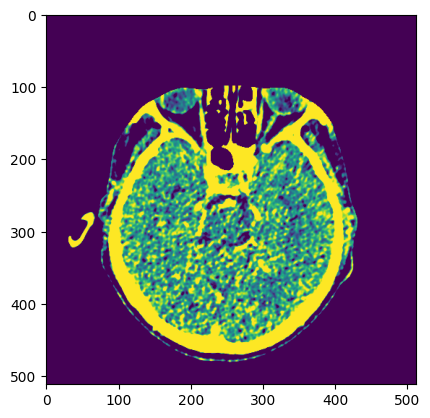

In [56]:
plt.imshow(imgslice)

In [61]:
imgslice

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(512, 512), dtype=uint8)

In [104]:
nvol = process_dicom_series(uid)

required


In [64]:
vol[54].min(), vol[54].max()

(np.uint8(0), np.uint8(255))

In [106]:
np.abs(vol[54] - nvol[162]).sum()
# np.allclose(imgslice,vol[54], atol=1)

np.uint64(0)

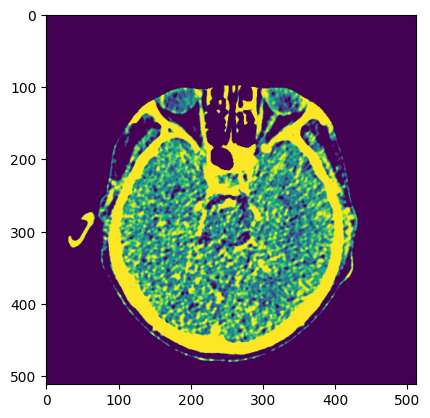

In [49]:
plt.imshow(vol[54])

In [48]:
fdf[fdf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.3599,54


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("../data/processed/train_df.csv")
labeldf = pd.read_csv("../data/processed/label_df.csv")

In [11]:
df.iloc[0]["Aneurysm Present"] == 0

np.True_

In [13]:
labels = sorted(labeldf.location.unique())

In [14]:
labels_to_idx = {label: idx for idx, label in enumerate(labels)}


In [16]:
df.fold_id.value_counts()

fold_id
4    852
0    852
3    852
2    852
1    852
Name: count, dtype: int64

In [15]:
labels_to_idx

{'Anterior Communicating Artery': 0,
 'Basilar Tip': 1,
 'Left Anterior Cerebral Artery': 2,
 'Left Infraclinoid Internal Carotid Artery': 3,
 'Left Middle Cerebral Artery': 4,
 'Left Posterior Communicating Artery': 5,
 'Left Supraclinoid Internal Carotid Artery': 6,
 'Other Posterior Circulation': 7,
 'Right Anterior Cerebral Artery': 8,
 'Right Infraclinoid Internal Carotid Artery': 9,
 'Right Middle Cerebral Artery': 10,
 'Right Posterior Communicating Artery': 11,
 'Right Supraclinoid Internal Carotid Artery': 12}

In [12]:
import numpy as np

In [7]:
vol = np.load("../data/processed/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647.npz")["vol"]

In [8]:
vol.min(), vol.max()

(np.uint8(0), np.uint8(255))

In [13]:
labels = np.load("../labels.npz")

In [15]:
labels["loc_probs"]

array([[7.7536441e-14, 1.8871692e-16, 7.7219969e-34, ..., 3.7263039e-14,
        1.3944598e-17, 2.3027832e-10],
       [7.1281448e-02, 3.8684748e-02, 1.2534111e-02, ..., 3.1759672e-02,
        1.2120609e-02, 1.5405468e-02],
       [1.3287560e-14, 1.3916444e-23, 0.0000000e+00, ..., 8.1876243e-21,
        1.0441280e-23, 1.9605383e-20],
       ...,
       [1.2658424e-04, 9.6793274e-06, 3.5416503e-12, ..., 2.5123625e-05,
        1.0904076e-05, 3.1840180e-05],
       [6.5045862e-14, 3.1105178e-21, 0.0000000e+00, ..., 1.3072217e-19,
        2.7670284e-20, 1.6746686e-19],
       [7.1281448e-02, 3.8684748e-02, 9.7588096e-03, ..., 3.1759672e-02,
        1.2120609e-02, 1.5405468e-02]], shape=(852, 13), dtype=float32)

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Items to choose from
items = list(range(200))

# Mean and standard deviation for Gaussian weights
mu = 100
sigma = 50

# Create Gaussian weights (not normalized)
weights = [math.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) for x in items]
# weights

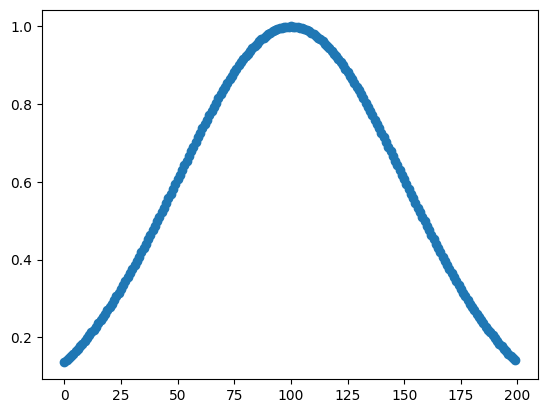

In [2]:
plt.scatter(items, weights)

In [5]:
# [w / sum(weights) for w in weights]

In [ ]:
# Discrete choices
items = np.arange(10)

# Gaussian parameters
mu = 5
sigma = 1.5

# Compute Gaussian-like weights (unnormalized)
weights = np.exp(-((items - mu) ** 2) / (2 * sigma ** 2))

# Normalize weights to sum to 1


In [45]:
import pydicom
import numpy as np
import matplotlib
matplotlib.use('Agg')  
import matplotlib.pyplot as plt
import pandas as pd
import os


def plot_npz(npz_path):
    with np.load(npz_path) as data:
        volume = data['vol']
        print(f"Volume shape: {volume.shape}")
        print(f"Number of slices: {volume.shape[0]}")
        return
        
        for i in range(volume.shape[0]):
            plt.figure(figsize=(8, 8))
            plt.imshow(volume[i], cmap='gray')
            plt.title(f'Slice {i+1}/{volume.shape[0]}')
            plt.axis('off')
            os.makedirs("all_slices_grid", exist_ok=True)
            plt.savefig(f"all_slices_grid/slice_{i+1:03d}.png", dpi=150, bbox_inches='tight')
            plt.close()
            
        print(f"Saved {volume.shape[0]} individual slice images")
        
        num_slices = volume.shape[0]
        cols = int(np.ceil(np.sqrt(num_slices)))
        rows = int(np.ceil(num_slices / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle(f'All {num_slices} slices', fontsize=16)
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        elif cols == 1:
            axes = axes.reshape(-1, 1)
            
        for i in range(num_slices):
            row = i // cols
            col = i % cols
            axes[row, col].imshow(volume[i], cmap='gray')
            axes[row, col].set_title(f'Slice {i+1}')
            axes[row, col].axis('off')
            
        for i in range(num_slices, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
            
        plt.tight_layout()
        os.makedirs("all_slices_grid", exist_ok=True)
        plt.savefig("all_slices_grid/all_slices_grid.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        print("Saved grid view as 'all_slices_grid.png'")

    #1.2.826.0.1.3680043.8.498.11466016618035234391071120016712127446


In [46]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [53]:
uid = train_df[train_df["Modality"] == "CTA"].iloc[2,0]

In [56]:
uid

'1.2.826.0.1.3680043.8.498.10021411248005513321236647460239137906'

In [54]:
train_df[train_df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
6,1.2.826.0.1.3680043.8.498.10021411248005513321...,55,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
import glob

In [22]:

p = glob.glob(f"../data/series/{uid}/*.dcm")[0]
pydicom.dcmread(p).Modality

'CT'

In [55]:
plot_npz(f"../data/processed/slices/{uid}.npz")

Volume shape: (80, 512, 512)
Number of slices: 80


In [4]:
train_df["Modality"]

NameError: name 'train_df' is not defined

In [15]:
plt.imshow(plt.imread("all_slices_grid/all_slices_grid.png"))
# plt.show()

In [25]:
from tqdm import tqdm

In [26]:
modalities = []

for uid in tqdm(train_df["SeriesInstanceUID"].unique()):
    p = glob.glob(f"../data/series/{uid}/*.dcm")[0]
    modalities.append(pydicom.dcmread(p).Modality)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4405/4405 [00:24<00:00, 180.38it/s]


In [27]:
from collections import Counter

In [28]:
Counter(modalities)

Counter({'MR': 2549, 'CT': 1856})

In [103]:
import pydicom
import numpy as np
import cv2
import pandas as pd

def preprocess_dcm_slice(dcm_path, output_size=(512, 512), window_level=150, window_width=350):
    """
    Reads and preprocesses a single DICOM slice from a CTA or MRA scan.

    For CTA scans, it applies a specific vascular window to highlight arteries.
    For other modalities like MRA, it performs standard min-max normalization.
    The final image is resized and returned as an 8-bit grayscale numpy array.

    Args:
        dcm_path (str): The full path to the .dcm file.
        output_size (tuple): The target dimensions for the output image (width, height).
        window_level (int): The window level (center) for CTA windowing in HU.
        window_width (int): The window width for CTA windowing in HU.

    Returns:
        numpy.ndarray: The preprocessed 8-bit grayscale image, or None if an error occurs.
    """
    try:
        # 1. Read the DICOM file using pydicom
        dcm = pydicom.dcmread(dcm_path)

        # Get the pixel data from the DICOM file
        image = dcm.pixel_array.astype(np.float64)

        # 2. Check if the modality is 'CT' to decide on the processing method
        # The DICOM tag (0008,0060) specifies the modality
        is_ct_scan = 'CT' in dcm.get('Modality', '').upper()

        if is_ct_scan:
            # For CT scans, convert pixel data to Hounsfield Units (HU)
            # using the Rescale Slope and Intercept values from DICOM metadata
            if 'RescaleSlope' in dcm and 'RescaleIntercept' in dcm:
                image = image * dcm.RescaleSlope + dcm.RescaleIntercept

            # Apply the vascular windowing
            lower_bound = window_level - (window_width / 2)
            upper_bound = window_level + (window_width / 2)
            
            # Clip the image to the window range
            image = np.clip(image, lower_bound, upper_bound)
            
            # Normalize the windowed image to a 0-255 scale
            image = ((image - lower_bound) / window_width) * 255.0

        else:
            # 3. For non-CT scans (like MRA), perform standard min-max normalization
            if np.max(image) != np.min(image):
                image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255.0

        # Convert the final processed image to an 8-bit unsigned integer format
        image = image.astype(np.uint8)

        # 4. Resize the image to the desired output size
        processed_image = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)

        return processed_image

    except Exception as e:
        print(f"Error processing the file {dcm_path}: {e}")
        return None




def apply_dicom_windowing(img: np.ndarray, window_center: float, window_width: float, preserve_contrast=True) -> np.ndarray:
    img_min = window_center - window_width / 2
    img_max = window_center + window_width / 2
    img_clipped = np.clip(img, img_min, img_max)
    img_normalized = (img_clipped - img_min) / (img_max - img_min + 1e-7)
    img_processed = (img_normalized * 255).astype(np.uint8)
    if preserve_contrast:
        img_processed = cv2.equalizeHist(img_processed)
    return img_processed

def get_windowing_params(modality: str) -> tuple[float, float]:
    """Get appropriate windowing for different modalities"""
    windows = {
        'CT': (40, 80),
        'CTA': (50, 350),
        'MR': (600, 1200),
        'MRA': (600, 1200),
        'MRI': (40, 80),
    }
    return windows.get(modality, (40, 80))


def process_slice(img,ds,modality):
    # modality = getattr(ds, 'Modality', 'CT')

    # Apply rescale if available
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept

    window_center, window_width = get_windowing_params(modality)
    img = apply_dicom_windowing(img, window_center, window_width)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img


In [104]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [105]:
train_df["Modality"].unique()

array(['MRA', 'CTA', 'MRI T2', 'MRI T1post'], dtype=object)

In [106]:
import glob
import matplotlib.pyplot as plt

In [107]:
IMG_SIZE = 512

In [116]:
uid = train_df[train_df["Modality"] == "MRI T2"].iloc[0,0]

dcm_path = glob.glob(f"../data/series/{uid}/*.dcm")[0]
# print(dcm_path)
ds = pydicom.dcmread(dcm_path)
# vol = 

In [119]:
preprocess_dcm_slice(dcm_path).shape

(512, 512, 512)

In [109]:
# plt.imshow()
# 
# preprocess_dcm_slice(dcm_path).shape


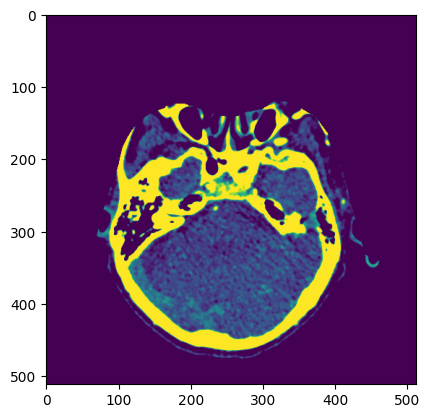

In [114]:

plt.imshow(preprocess_dcm_slice(dcm_path))

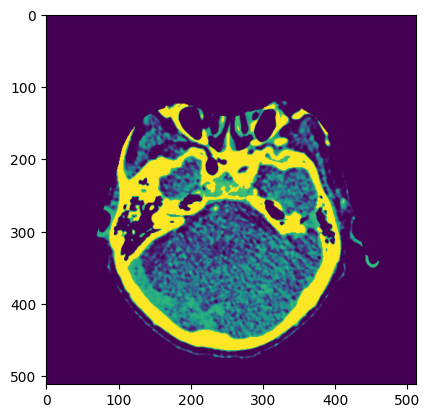

In [113]:
plt.imshow(cv2.equalizeHist(preprocess_dcm_slice(dcm_path)))

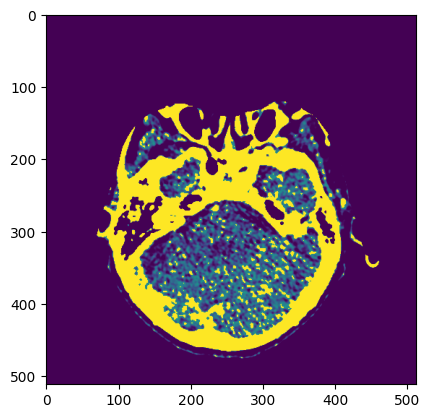

In [111]:
plt.imshow(process_slice(ds.pixel_array, ds, ds.Modality))

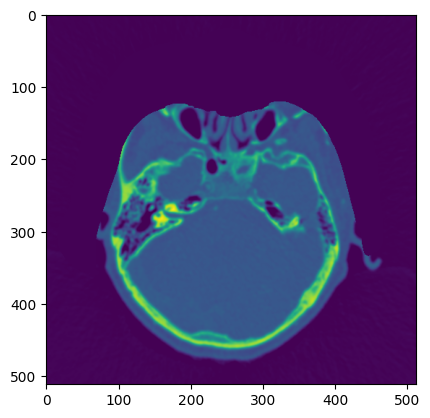

In [112]:

plt.imshow(ds.pixel_array)

In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader, Dataset

# # --- Helper Functions and Dummy Classes (Replace with your actual code) ---

# # ==> TODO: Replace this with your list of class names
# CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumonia']
# NUM_CLASSES = len(CLASS_NAMES)

# # 1. ==> TODO: Replace this dummy Dataset with your actual Dataset class.
# # This class simulates loading slices from .npz volumes.
# class NpzSliceDataset(Dataset):
#     """
#     A dummy dataset that simulates loading image slices and labels.
#     REPLACE THIS WITH YOUR ACTUAL DATASET IMPLEMENTATION.
#     """
#     def __init__(self, is_dummy=True):
#         print("--- Using dummy data. Replace NpzSliceDataset with your dataset. ---")
#         num_volumes = 5
#         slices_per_volume = 50
#         image_size = 64
#         # Simulating 5 volumes, each with 50 slices of 64x64 images
#         self.image_slices = np.random.rand(num_volumes * slices_per_volume, image_size, image_size).astype(np.float32)
#         # Simulating multi-label targets
#         self.labels = np.random.randint(0, 2, size=(num_volumes * slices_per_volume, NUM_CLASSES)).astype(np.float32)

#     def __len__(self):
#         return len(self.image_slices)

#     def __getitem__(self, idx):
#         image = self.image_slices[idx]
#         label = self.labels[idx]

#         # Add channel dimension for CNN (C, H, W) and convert to tensor
#         image_tensor = torch.from_numpy(image).unsqueeze(0)
#         label_tensor = torch.from_numpy(label)

#         return image_tensor, label_tensor

# # 2. ==> TODO: Replace this dummy Model with your actual nn.Module class.
# class SimpleCNN(nn.Module):
#     """
#     A dummy CNN model.
#     REPLACE THIS WITH YOUR ACTUAL MODEL ARCHITECTURE.
#     """
#     def __init__(self, num_classes):
#         super().__init__()
#         print("--- Using dummy model. Replace SimpleCNN with your model architecture. ---")
#         self.conv_stack = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(32 * 16 * 16, 128),
#             nn.ReLU(),
#             nn.Linear(128, num_classes)
#         )
#         # NOTE: We output raw logits, not probabilities. No final Sigmoid layer.
#         # This is the standard practice when using BCEWithLogitsLoss.

#     def forward(self, x):
#         x = self.conv_stack(x)
#         return self.classifier(x)

# # --- Main Debugging Code ---

# def analyze_validation_set(model, val_loader, device):
#     """
#     Analyzes the model's performance on the validation set,
#     identifying samples with the highest loss.
#     """
#     model.eval()  # Set the model to evaluation mode
#     all_results = []
    
#     # Using BCEWithLogitsLoss is recommended. 
#     # The 'reduction="none"' argument is CRUCIAL to get per-element loss.
#     loss_fn = nn.BCEWithLogitsLoss(reduction='none')

#     print("\nRunning analysis on validation set...")
#     with torch.no_grad(): # Disable gradient calculations for inference
#         for images, true_labels in val_loader:
#             images = images.to(device)
#             true_labels = true_labels.to(device)

#             # Get model predictions (raw logits)
#             logits = model(images)
            
#             # Calculate loss for EACH sample and EACH class in the batch
#             per_element_loss = loss_fn(logits, true_labels)
            
#             # Sum the loss across the classes for each sample to get a single loss value per image
#             per_sample_loss = per_element_loss.sum(axis=1)

#             # Get predicted probabilities (by applying sigmoid to logits) for analysis
#             probs = torch.sigmoid(logits)

#             # Store results for each item in the batch
#             for i in range(images.size(0)):
#                 all_results.append({
#                     "image": images[i].cpu(),
#                     "true_labels": true_labels[i].cpu().numpy(),
#                     "predictions": probs[i].cpu().numpy(),
#                     "loss": per_sample_loss[i].item()
#                 })

#     # Sort all results by loss in descending order
#     # The first items in this list are your "worst offenders"
#     sorted_results = sorted(all_results, key=lambda x: x['loss'], reverse=True)
    
#     print(f"Analysis complete. Found {len(sorted_results)} validation samples.")
#     print(f"Top 5 sample losses: {[f'{res["loss"]:.4f}' for res in sorted_results[:5]]}")
    
#     return sorted_results


# def visualize_worst_predictions(sorted_results, class_names, num_to_show=5):
#     """
#     Visualizes the images that the model performed worst on.
#     """
#     print(f"\n--- Displaying Top {num_to_show} Worst Predictions ---")
    
#     for i, result in enumerate(sorted_results[:num_to_show]):
#         image = result['image'].squeeze() # Remove channel dim for plotting
#         true_labels = result['true_labels']
#         predictions = result['predictions']
#         loss = result['loss']
        
#         fig = plt.figure(figsize=(9, 5))
        
#         # Display the image
#         ax_img = plt.subplot(1, 2, 1)
#         ax_img.imshow(image, cmap='gray')
#         ax_img.set_title(f"Rank {i+1} Worst | Loss: {loss:.4f}")
#         ax_img.axis('off')
        
#         # Display the labels and predictions
#         ax_text = plt.subplot(1, 2, 2)
#         ax_text.axis('off')
#         info_text = "Label Predictions (True vs. Pred)\n" + "-"*35 + "\n"
#         for j, name in enumerate(class_names):
#             true_val = int(true_labels[j])
#             pred_val = predictions[j]
#             # Highlight confident wrong predictions that cause high loss
#             is_wrong_and_confident = (abs(true_val - pred_val) > 0.8)
#             highlight_char = "🔥" if is_wrong_and_confident else ""
#             info_text += f"{name:<15}: {true_val} vs {pred_val:.3f} {highlight_char}\n"
        
#         ax_text.text(0, 0.5, info_text, ha='left', va='center', fontsize=11, fontfamily='monospace')
#         plt.tight_layout()
#         plt.show()

# # --- How to Run ---

# if __name__ == '__main__':
#     # 1. Setup device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
    
#     # 2. ==> TODO: Load your trained model
#     # model_path = 'path/to/your/best_model.pth' # <-- IMPORTANT: Set your model path
#     model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
#     # try:
#     #     model.load_state_dict(torch.load(model_path, map_location=device))
#     #     print(f"Model loaded from {model_path}")
#     # except FileNotFoundError:
#     print("--- Using a randomly initialized dummy model for demonstration. ---")

#     # 3. ==> TODO: Create your validation dataset and loader
#     val_dataset = NpzSliceDataset() # Replace this line
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
#     # 4. Run the analysis
#     worst_predictions = analyze_validation_set(model, val_loader, device)
    
#     # 5. Visualize the results
#     if worst_predictions:
#         visualize_worst_predictions(worst_predictions, CLASS_NAMES, num_to_show=5)

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
from src.rsna_datasets.datasets import *
from src.model import *
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn.functional as F

/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/torchmetrics/__init__.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  import scipy.signal
/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
model = MultiBackboneModel("efficientnet_b2", 3, 512)
model.load_state_dict(torch.load("../rsna-iad-modelzoo/efficient_b2_depth_slices-epoch=41-val_loss=0.8268_fold_id=0.pth"))
model.eval().cuda()
print("Done")

Model efficientnet_b2: detected 1408 features, output shape: torch.Size([1, 1408, 16, 16])
Done


In [5]:
def create_rgb_slices(volume):

    D, H, W = volume.shape
    rgb_slices = []

    for i in range(0, D):
        rgb = np.stack([volume[max(0, i - 1)], volume[i], volume[min(i + 1, D - 1)]], axis=0)
        rgb_slices.append(rgb)

    return np.stack(rgb_slices, axis=0)

mean = np.array([0.485, 0.485, 0.485], dtype=np.float32).reshape((1,3,1,1))
std = np.array([0.229, 0.229, 0.229], dtype=np.float32).reshape((1,3,1,1))


@torch.no_grad()
def eval_one_series(uid, modality, volume, model, cls_label, loc_labels):

    d = volume.shape[0]

    volume = create_rgb_slices(volume)
    volume = (volume / 255 - mean) / std
    volume = torch.from_numpy(volume).cuda()

    pred_cls = []
    pred_locs = []

    for batch_idx in range(0,volume.shape[0], 64):
        pc,pl = model(volume[batch_idx:batch_idx+64])
        pred_cls.append(pc)
        pred_locs.append(pl)

    pred_cls = torch.vstack(pred_cls)
    pred_locs = torch.vstack(pred_locs)

    pred_cls = pred_cls.squeeze()

    # pred_cls = pred_cls.cpu()
    # pred_locs = 
    losses = F.binary_cross_entropy_with_logits(pred_cls, torch.from_numpy(cls_label).cuda(), reduction="none")

    result = []

    for i in range(d):
        result.append( {
            "uid": uid,
            "index": i,
            "modality": modality,
            "loss": losses[i],
            "label": cls_label[i].item(),
            "pred": pred_cls[i].sigmoid().item()
        })
    

    return result


In [6]:
LABELS_TO_IDX = {
    'Anterior Communicating Artery': 0,
    'Basilar Tip': 1,
    'Left Anterior Cerebral Artery': 2,
    'Left Infraclinoid Internal Carotid Artery': 3,
    'Left Middle Cerebral Artery': 4,
    'Left Posterior Communicating Artery': 5,
    'Left Supraclinoid Internal Carotid Artery': 6,
    'Other Posterior Circulation': 7,
    'Right Anterior Cerebral Artery': 8,
    'Right Infraclinoid Internal Carotid Artery': 9,
    'Right Middle Cerebral Artery': 10,
    'Right Posterior Communicating Artery': 11,
    'Right Supraclinoid Internal Carotid Artery': 12
}


LABELS = sorted(list(LABELS_TO_IDX.keys()))


In [7]:

df = pd.read_csv("../data/processed/train_df.csv")
labels_df = pd.read_csv("../data/processed/label_df.csv")
fold_df = df[df["fold_id"] == 0]
fold_uids = list(fold_df["SeriesInstanceUID"])
# val_transforms = A.Compose([ A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) ])


In [8]:
from tqdm import tqdm

In [9]:
fold_results = []

for uid in tqdm(fold_uids):

    rowdf = df[df["SeriesInstanceUID"] == uid]
    uid_labels = labels_df[labels_df["SeriesInstanceUID"] == uid]




    with np.load(f"../data/processed/slices/{uid}.npz") as data:
        volume = data['vol'].astype(np.float32)
        
        loc_labels = np.zeros((volume.shape[0], 13))
        cls_labels = np.zeros(volume.shape[0])

        if uid_labels.shape[0] != 0:
            for z in uid_labels["z"]:
                cls_labels[z] = 1

        fold_results.extend(eval_one_series(uid, rowdf["Modality"].iloc[0], volume, model, cls_labels, loc_labels))
    
        # pred_cls_probs.append(cls_prob)
        # pred_loc_probs.append(loc_probs)

    # break
    
    # loc_label = np.zeros(13)
    
    # for idx, label in enumerate(LABELS):
    #     loc_label[idx] = int(rowdf[label].iloc[0])
    
    # cls_labels.append(rowdf["Aneurysm Present"].iloc[0])
    # loc_labels.append(loc_label)
    


    # with np.load(f"../data/processed/slices/{uid}.npz") as data
    #     volume = data["vol"]
    # pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 852/852 [03:45<00:00,  3.79it/s]


In [10]:
fold_results = sorted(fold_results, key = lambda r: r["loss"])

In [11]:
import matplotlib.pyplot as plt

In [88]:
def view_result(result):
    print(result)
    vol = np.load(f"../data/processed/slices/{result['uid']}.npz")["vol"]
    print(vol.shape)
    plt.imshow(vol[result['index']])
    # pass

{'uid': '1.2.826.0.1.3680043.8.498.10725297140806487146802258546172418874', 'index': 111, 'modality': 'CTA', 'loss': tensor(2.4288, device='cuda:0', dtype=torch.float64), 'label': 0.0, 'pred': 0.9118605256080627}
(256, 512, 512)


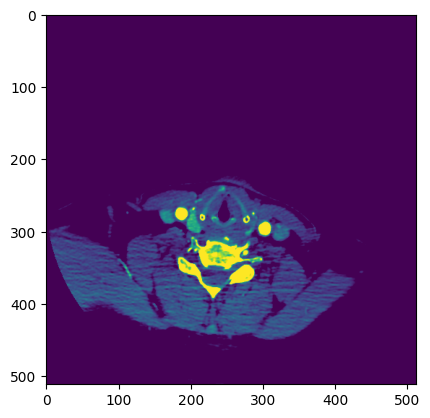

In [89]:
view_result(fold_results[-120])

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve

In [17]:
dfv0 = pd.read_csv("./preds.csv")


--- Data successfully loaded into DataFrame ---
                                                 uid  index modality  \
0  1.2.826.0.1.3680043.8.498.10865633197287573811...      4      CTA   
1  1.2.826.0.1.3680043.8.498.66535042290403236099...     21      CTA   
2  1.2.826.0.1.3680043.8.498.77304461552507049962...     82      CTA   
3  1.2.826.0.1.3680043.8.498.77304461552507049962...     80      CTA   
4  1.2.826.0.1.3680043.8.498.77304461552507049962...     81      CTA   

       loss  label      pred  pred_label  is_correct  
0  0.000017    0.0  0.000017           0           1  
1  0.000017    0.0  0.000017           0           1  
2  0.000021    0.0  0.000021           0           1  
3  0.000022    0.0  0.000022           0           1  
4  0.000022    0.0  0.000022           0           1  
['1.2.826.0.1.3680043.8.498.10865633197287573811696664187842772441', '1.2.826.0.1.3680043.8.498.66535042290403236099478574252770233908', '1.2.826.0.1.3680043.8.498.773044615525070499622522

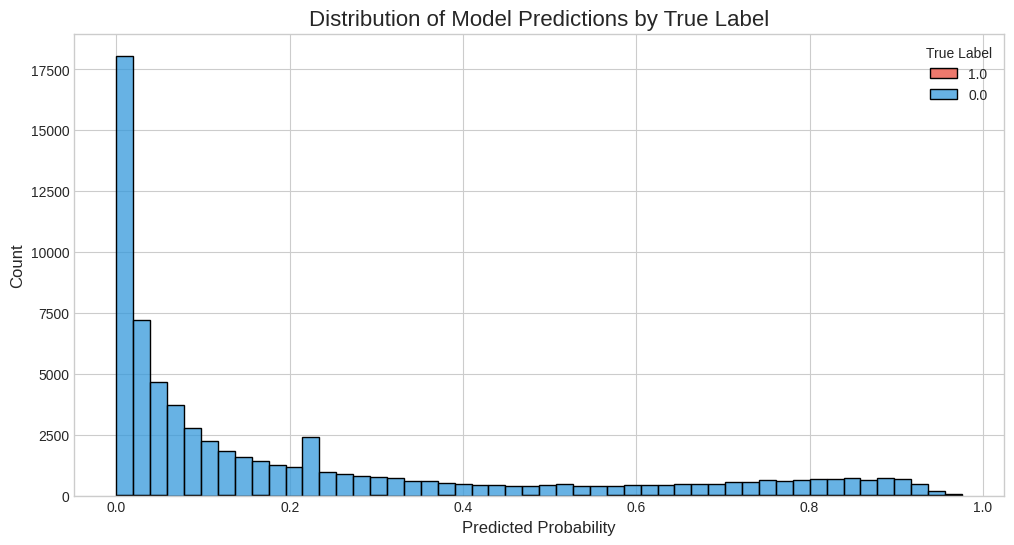

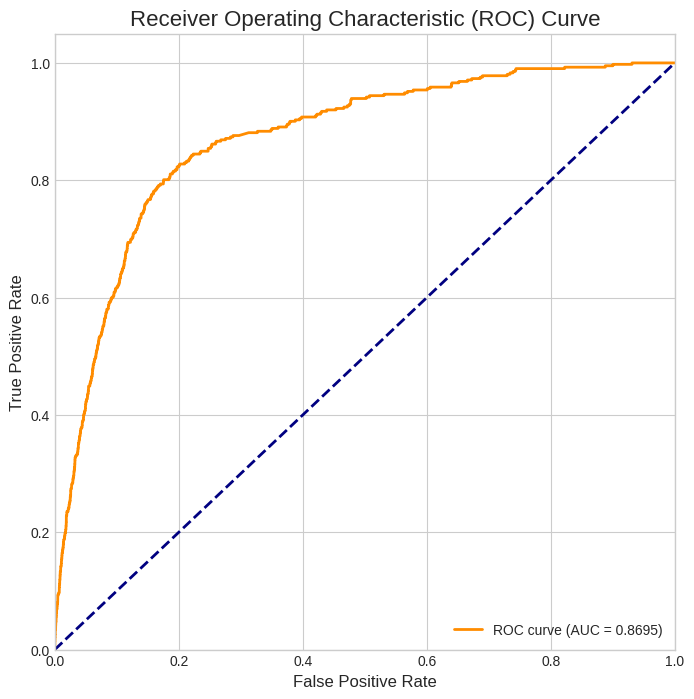

In [47]:
# --- 2. Data Preparation ---
# Convert the list of dictionaries into a Pandas DataFrame for easy analysis.
# df = dfv0

df = dfv0
# df['loss'] = df['loss'].apply(lambda x: x.cpu().item())

# Clean up the data:
# Move 'loss' from CUDA tensor to a simple float

# Create a binary prediction label based on a 0.5 threshold
df['pred_label'] = (df['pred'] > 0.5).astype(int)
# Add a column to easily identify correct/incorrect predictions
df['is_correct'] = (df['label'] == df['pred_label']).astype(int)

# df = df[df["label"] == 1]

print("\n--- Data successfully loaded into DataFrame ---")
print(df.head())
print(df.head()["uid"].tolist())

# --- 3. Overall Performance Analysis ---
print("\n" + "="*50)
print("✅ Overall Performance Metrics")
print("="*50)

avg_loss = df['loss'].mean()
accuracy = accuracy_score(df['label'], df['pred_label'])
auc_score = roc_auc_score(df['label'], df['pred'])

print(f"Total Samples: {len(df)}")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC ROC Score: {auc_score:.4f}")

# --- 4. Error Analysis: Finding the Worst Predictions ---
print("\n" + "="*50)
print("🔥 Top 5 Worst Predictions (Highest Loss)")
print("="*50)
print(df.sort_values(by='loss', ascending=False).head(5))


# Identify top False Positives (predicted 1, actually 0)
fp_df = df[(df['label'] == 0) & (df['pred_label'] == 1)]
print("\n--- Top 5 Confident False Positives ---")
print(fp_df.sort_values(by='pred', ascending=False).head(5))
print(fp_df.head(5)["uid"].tolist())

# Identify top False Negatives (predicted 0, actually 1)
fn_df = df[(df['label'] == 1) & (df['pred_label'] == 0)]
print("\n--- Top 5 Confident False Negatives ---")
print(fn_df.sort_values(by='pred', ascending=True).head(5))


# --- 5. Grouped Analysis by Modality ---
print("\n" + "="*50)
print("📊 Performance by Modality")
print("="*50)

modality_performance = df.groupby('modality').agg(
    count=('uid', 'size'),
    avg_loss=('loss', 'mean'),
    accuracy=('is_correct', 'mean'),
    # AUC requires both predictions and labels, so we use a lambda function
    auc=('pred', lambda x: roc_auc_score(df.loc[x.index, 'label'], x))
).round(4)

print(modality_performance)


# --- 6. Visualization ---
print("\n" + "="*50)
print("📈 Visualizing Results")
print("="*50)

plt.style.use('seaborn-v0_8-whitegrid')

# 6.1. Distribution of Predictions
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='pred', hue='label', multiple='stack', bins=50, palette=['#3498db', '#e74c3c'])
plt.title('Distribution of Model Predictions by True Label', fontsize=16)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='True Label', labels=['1.0', '0.0'])
plt.show()


# 6.2. ROC Curve
fpr, tpr, thresholds = roc_curve(df['label'], df['pred'])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()


In [35]:
resv1 = df.groupby("uid").max("pred")
roc_auc_score(resv1["label"], resv1["pred"])

np.float64(0.7748751046728227)

In [27]:
resv0 = dfv0.groupby("uid").max("pred")
roc_auc_score(resv0["label"], resv0["pred"])

np.float64(0.6682256033996593)

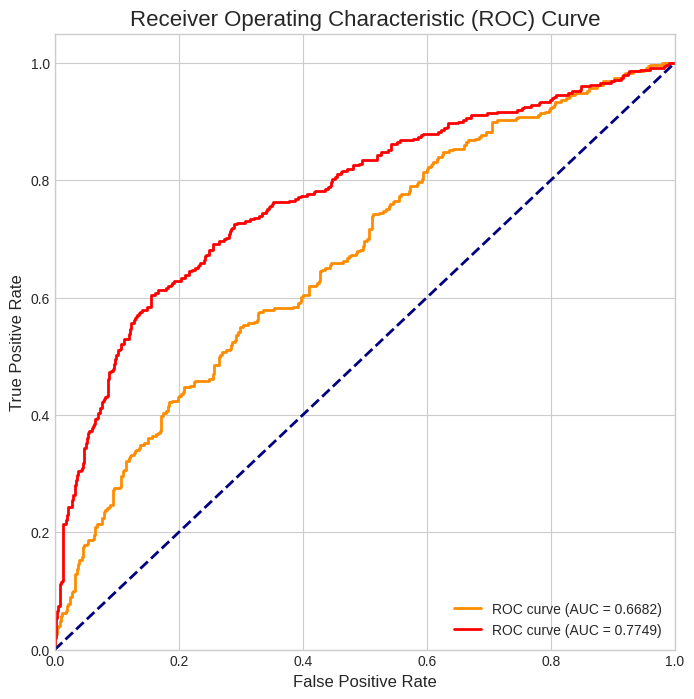

In [33]:
# 6.2. ROC Curve
plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(resv0['label'], resv0['pred'])
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(resv0["label"], resv0["pred"]):.4f})')

fpr, tpr, thresholds = roc_curve(resv1['label'], resv1['pred'])
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_score(resv1["label"], resv1["pred"]):.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()


In [36]:
"""
Total Samples: 412
Average Loss: 0.2894
Accuracy: 0.8617
AUC ROC Score: nan

            count  avg_loss  accuracy  auc
modality                                  
CTA           222    0.2481    0.8694  NaN
MRA           118    0.1685    0.9407  NaN
MRI T1post     22    0.6616    0.6818  NaN
MRI T2         50    0.5941    0.7200  NaN
"""

'\nTotal Samples: 412\nAverage Loss: 0.2894\nAccuracy: 0.8617\nAUC ROC Score: nan\n\n            count  avg_loss  accuracy  auc\nmodality                                  \nCTA           222    0.2481    0.8694  NaN\nMRA           118    0.1685    0.9407  NaN\nMRI T1post     22    0.6616    0.6818  NaN\nMRI T2         50    0.5941    0.7200  NaN\n'

In [41]:
import numpy as np

In [96]:
train_df = pd.read_csv("../data/processed/train_df.csv")
label_df = pd.read_csv("../data/processed/label_df.csv")

1.2.826.0.1.3680043.8.498.24941924992372724575490063788348447936 25 60


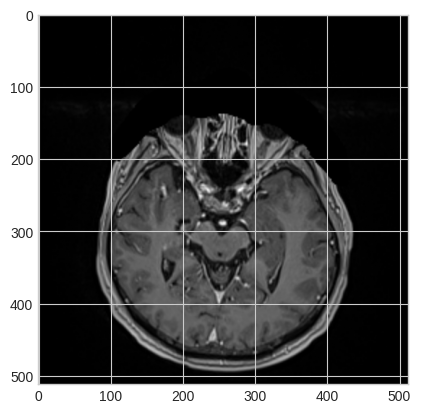

In [107]:
# uid = "1.2.826.0.1.3680043.8.498.22312607603284694139267585184483668731 1.2.826.0.1.3680043.8.498.22312607603284694139267585184483668731"
idx = 12
uid,slice_idx = stuff[idx]
vol = np.load(f"../data/processed/slices/{uid}.npz")["vol"]
plt.imshow(vol[slice_idx], cmap="gray")

print(uid, slice_idx, vol.shape[0])


In [108]:
train_df[train_df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,fold_id
1608,1.2.826.0.1.3680043.8.498.24941924992372724575...,72,Male,MRI T1post,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [109]:
label_df[label_df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
884,1.2.826.0.1.3680043.8.498.24941924992372724575...,1.2.826.0.1.3680043.8.498.74864554133216834829...,Right Middle Cerebral Artery,84.383436,120.282004,33


In [110]:
df[(df["modality"] == "CTA") & (df["pred_label"] == 1)].head()

,uid,index,modality,loss,label,pred,pred_label,is_correct
21631,1.2.826.0.1.3680043.8.498.31629979420404800139...,44,CTA,0.028269,1.0,0.972127,1,1
22324,1.2.826.0.1.3680043.8.498.77304461552507049962...,39,CTA,0.030227,1.0,0.970226,1,1
23105,1.2.826.0.1.3680043.8.498.31629979420404800139...,43,CTA,0.032526,1.0,0.967998,1,1
24279,1.2.826.0.1.3680043.8.498.29753357190941806548...,51,CTA,0.036430,1.0,0.964225,1,1
24437,1.2.826.0.1.3680043.8.498.31629979420404800139...,46,CTA,0.036906,1.0,0.963767,1,1


In [101]:

fpdf = df[(df["modality"] == "MRI T1post") & (df["pred_label"] == 1) & (df["is_correct"] == 0)].sort_values(by="pred", ascending=False)

In [102]:
stuff = [*zip(fpdf["uid"], fpdf["index"])]

In [103]:
len(stuff)

339

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import timm
#from timm.models.convnext import *


#------------------------------------------------
# processing

def encode_for_resnet(e, x, B, depth_scaling=[2,2,2,2,1]):

    def pool_in_depth(x, depth_scaling):
        bd, c, h, w = x.shape

        # Batch * Depth

        # B, D, C, H, W -> B, C, D, H, W
        x1 = x.reshape(B, -1, c, h, w).permute(0, 2, 1, 3, 4)
        
        x1 = F.avg_pool3d(x1, kernel_size=(depth_scaling, 1, 1), stride=(depth_scaling, 1, 1), padding=0)
        x = x1.permute(0, 2, 1, 3, 4).reshape(-1, c, h, w)
        return x, x1

    encode=[]
    x = e.conv1(x)
    x = e.bn1(x)
    x = e.act1(x)

    x, x1 = pool_in_depth(x, depth_scaling[0])
    encode.append(x1)
    #print(x.shape)

    #x = e.maxpool(x)
    x = F.avg_pool2d(x,kernel_size=2,stride=2)

    x = e.layer1(x)
    x, x1 = pool_in_depth(x, depth_scaling[1])
    encode.append(x1)
    #print(x.shape)

    x = e.layer2(x)
    x, x1 = pool_in_depth(x, depth_scaling[2])
    encode.append(x1)
    #print(x.shape)

    x = e.layer3(x)
    x, x1 = pool_in_depth(x, depth_scaling[3])
    encode.append(x1)
    #print(x.shape)

    x = e.layer4(x)
    x, x1 = pool_in_depth(x, depth_scaling[4])
    encode.append(x1)
    #print(x.shape)

    return x
    
class Net(nn.Module):
    def __init__(self, pretrained=False, cfg=None):
        super(Net, self).__init__()
        self.output_type = ['infer', 'loss', ]
        self.register_buffer('D', torch.tensor(0))


        num_class=6+1

        self.arch = 'resnet34d'
        if cfg is not None:
            self.arch = cfg.arch

        encoder_dim = {
            'resnet18': [64, 64, 128, 256, 512, ],
            'resnet18d': [64, 64, 128, 256, 512, ],
            'resnet34d': [64, 64, 128, 256, 512, ],
            'resnet50d': [64, 256, 512, 1024, 2048, ],
            'seresnext26d_32x4d': [64, 256, 512, 1024, 2048, ],
            'convnext_small.fb_in22k': [96, 192, 384, 768],
            'convnext_tiny.fb_in22k': [96, 192, 384, 768],
            'convnext_base.fb_in22k': [128, 256, 512, 1024],
            'tf_efficientnet_b4.ns_jft_in1k':[32, 56, 160, 448],
            'tf_efficientnet_b5.ns_jft_in1k':[40, 64, 176, 512],
            'tf_efficientnet_b6.ns_jft_in1k':[40, 72, 200, 576],
            'tf_efficientnet_b7.ns_jft_in1k':[48, 80, 224, 640],
            'pvt_v2_b1': [64, 128, 320, 512],
            'pvt_v2_b2': [64, 128, 320, 512],
            'pvt_v2_b4': [64, 128, 320, 512],
        }.get(self.arch, [768])
        decoder_dim = \
              [384, 192, 96, 32, 16]

        self.encoder = timm.create_model(
            model_name=self.arch, pretrained=pretrained, in_chans=3, num_classes=0, global_pool='', features_only=True,
        )


        self.global_pool = nn.AdaptiveAvgPool2d(1)
        


    def forward(self, batch):
        device = self.D.device

        image = batch['image'].to(device)
        B, D, H, W = image.shape
        image = image.reshape(B*D, 1, H, W)

        x = (image.float() - 0.5) / 0.5
        x = x.expand(-1, 3, -1, -1)

        x = encode_for_resnet(self.encoder, x, B, depth_scaling=[2,2,2,2,2])

        x = self.global_pool(x).squeeze()

        print(x.shape)
        
        return x
        # #[print(f'encode_{i}', e.shape) for i,e in enumerate(encode)]


        # #[print(f'encode_{i}', e.shape) for i, e in enumerate(encode)]
        # last, decode = self.decoder(
        #     feature=encode[-1], skip=encode[:-1][::-1]+[None], depth_scaling=[1,2,2,2,2]
        # )
        # #print(f'last', last.shape)


        # logit = self.mask(last)
        # #print('logit', logit.shape)


        # output = {}
        # if 'loss' in self.output_type:
        #     #<todo> weighted cross entropy
        #     output['mask_loss'] = F.cross_entropy(logit, batch['mask'].to(device))

        # if 'infer' in self.output_type:
        #     output['particle'] = F.softmax(logit,1)

        # return output



#------------------------------------------------------------------------
def run_check_net():

    B = 4
    image_size = 640
    mask_size  = 640
    num_slice = 32 #184
    num_class=6+1

    batch = {
        'image': torch.from_numpy(np.random.uniform(0,1, (B,num_slice, image_size, image_size))).float(),
        'mask': torch.from_numpy(np.random.choice(num_class, (B, num_slice, mask_size, mask_size))).long(),
    }

    net = Net(pretrained=True, cfg=None).cuda()


    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)
    # # ---
    # print('batch')
    # for k, v in batch.items():
    #     if k == 'D':
    #         print(f'{k:>32} : {v} ')
    #     else:
    #         print(f'{k:>32} : {v.shape} ')

    # print('output')
    # for k, v in output.items():
    #     if 'loss' not in k:
    #         print(f'{k:>32} : {v.shape} ')
    # print('loss')
    # for k, v in output.items():
    #     if 'loss' in k:
    #         print(f'{k:>32} : {v.item()} ')


# main #################################################################
if __name__ == '__main__':
    run_check_net()

torch.Size([4, 512])


/tmp/ipykernel_144363/3005850743.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


In [1]:
import sys
sys.path.append("..")

In [2]:
from src.rsna_datasets.datasets_25D import *
from omegaconf import OmegaConf

/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/torchmetrics/__init__.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  import scipy.signal
/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
config = OmegaConf.load("../configs/config.yaml")

In [4]:
config["data_dir"] = "../data/processed"
config = OmegaConf.merge(config, {"model": {"num_classes": 13}})
# config["model"]["num_classes"] = 13

In [5]:
dm = NpzDataModule(config)
dm.setup()

In [6]:
dm.train_dataset.transform = None

In [73]:
import matplotlib.pyplot as plt

In [126]:
idx = 38
uid = dm.train_dataset.uids[idx]

dm.train_dataset.train_df[dm.train_dataset.train_df["SeriesInstanceUID"] == dm.train_dataset.uids[idx]]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,fold_id
51,1.2.826.0.1.3680043.8.498.10133805409448598100...,64,Male,CTA,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4


In [127]:
sample,cls,loc = dm.train_dataset[idx]

In [128]:
with np.load(f"../data/processed/slices/{uid}.npz") as data:
        vol = data["vol"]
        print(vol.shape)

(186, 512, 512)


In [ ]:

plt.imshow(cv2.equalizeHist(vol.max(axis=0)), cmap="gray")

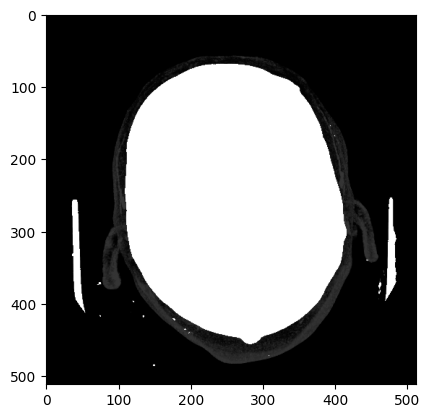

In [130]:
plt.imshow(cv2.equalizeHist(vol.max(axis=0)), cmap="gray")

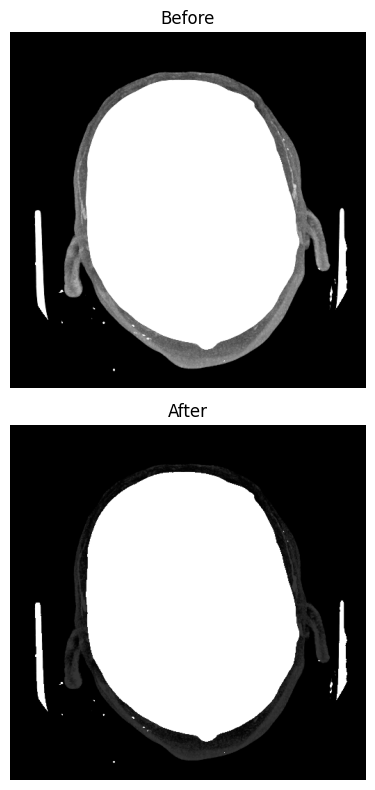

In [133]:



# Create figure with 2 rows, 1 column
fig, axes = plt.subplots(2, 1, figsize=(5, 8))

# First image (top)
axes[0].imshow(vol.max(axis=0), cmap='gray')
axes[0].set_title("Before")
axes[0].axis('off')  # hide axes

# Second image (bottom)
axes[1].imshow(cv2.equalizeHist(vol.max(axis=0)), cmap='gray')
axes[1].set_title("After")
axes[1].axis('off')

plt.tight_layout()
plt.show()


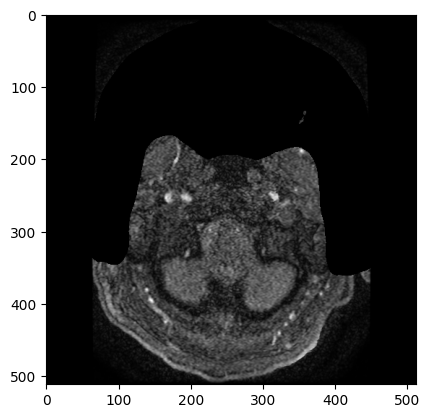

In [78]:
plt.imshow(sample[0], cmap="gray")

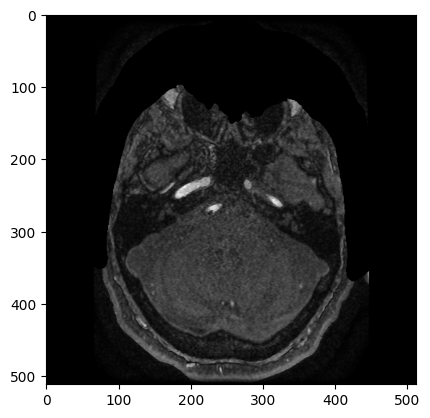

In [79]:

plt.imshow(sample[11], cmap="gray")

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,fold_id
28,1.2.826.0.1.3680043.8.498.10073947840865129766...,78,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [71]:

dm.train_dataset.label_df[dm.train_dataset.label_df["SeriesInstanceUID"] == dm.train_dataset.uids[idx]]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
11,1.2.826.0.1.3680043.8.498.10063454172499468887...,1.2.826.0.1.3680043.8.498.10281466791444873475...,Left Supraclinoid Internal Carotid Artery,392.309115,230.140029,0


In [136]:

dm.train_dataset.train_df[(dm.train_dataset.train_df["fold_id"] != 0) & dm.train_dataset.train_df["Modality"] != "CTA"]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,fold_id
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255,1.2.826.0.1.3680043.8.498.99915610493694667606...,62,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4256,1.2.826.0.1.3680043.8.498.99920680741054836990...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4257,1.2.826.0.1.3680043.8.498.99953513260518059135...,44,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4258,1.2.826.0.1.3680043.8.498.99982144859397209076...,58,Female,MRI T2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [176]:
import cv2

In [177]:
cta_preds = np.load("../labels.npz")

mr_preds = np.load("../mr_preds.npz")

[]

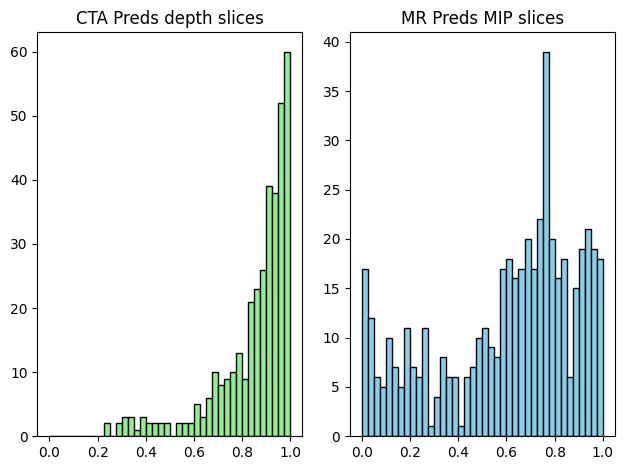

In [179]:
fig, axes = plt.subplots(1,2)

axes[0].hist(cta_preds["cls_probs"], bins=40, range=(0, 1), color='lightgreen', edgecolor='black')
axes[0].set_title("CTA Preds depth slices")
axes[1].hist(mr_preds["cls_probs"], bins=40, range=(0, 1), color='skyblue', edgecolor='black')
axes[1].set_title("MR Preds MIP slices")
plt.tight_layout()
plt.plot()


[]

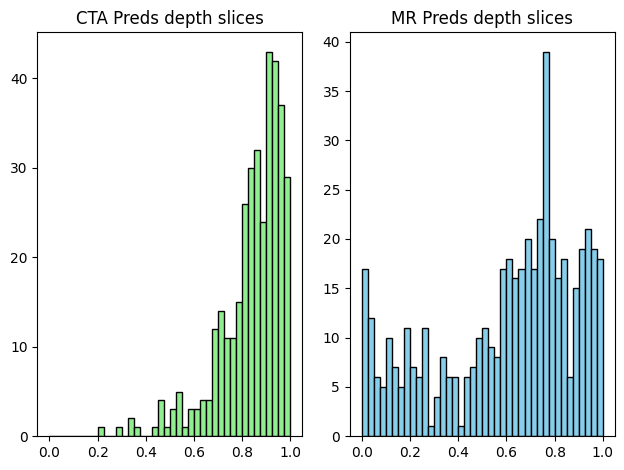

In [172]:

fig, axes = plt.subplots(1,2)

axes[0].hist(cta_preds["cls_probs"], bins=40, range=(0, 1), color='lightgreen', edgecolor='black')
axes[0].set_title("CTA Preds depth slices")
axes[1].hist(mr_preds["cls_probs"], bins=40, range=(0, 1), color='skyblue', edgecolor='black')
axes[1].set_title("MR Preds depth slices")
plt.tight_layout()
plt.plot()

# probs = stuff["cls_probs"]
# plt.hist(probs, bins=40, range=(0, 1), color='skyblue', edgecolor='black')
# plt.xlabel("Probability")
# plt.ylabel("Frequency")
# plt.title("Histogram of Probabilities")
# plt.show()


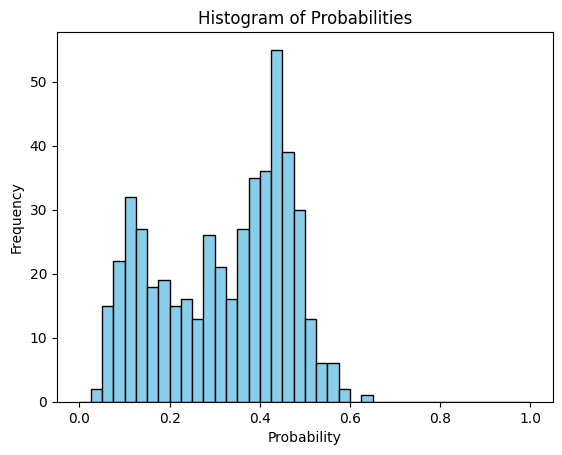

In [142]:


probs = stuff["cls_probs"]
plt.hist(probs, bins=40, range=(0, 1), color='skyblue', edgecolor='black')
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Probabilities")
plt.show()


In [159]:
dm.train_dataset.train_df["Modality"].unique()

array(['MRA', 'CTA', 'MRI T2', 'MRI T1post'], dtype=object)